In [1]:
import tensorflow as tf
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm

train_path = r"D:\Pressure Ulcer\Thesis Data\train_data\aug_data/"
test_path = r"D:\Pressure Ulcer\Thesis Data\test data/"

train_img_path = glob(train_path + "images/*")
train_msk_path = glob(train_path + "masks/*")
test_img_path = glob(test_path + "images/*")
test_msk_path = glob(test_path + "masks/*")

In [2]:
train_imgs = []
train_msks = []
test_imgs = []
test_msks = []

for img_path in tqdm(train_img_path):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    train_imgs.append(img)
for img_path in tqdm(test_img_path):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    test_imgs.append(img)   
    
for msk_path in tqdm(train_msk_path):
    msk = cv2.imread(msk_path, 0)
    #msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    msk = msk/255.0
    train_msks.append(msk)
for msk_path in tqdm(test_msk_path):
    msk = cv2.imread(msk_path, 0)
    #msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    msk = msk/255.0
    test_msks.append(msk)

100%|██████████| 73/73 [00:00<00:00, 97.18it/s]


In [3]:
X = np.array(train_imgs)
y = np.array(train_msks)
y = np.expand_dims(y , axis=-1)

X_test = np.array(test_imgs)
y_test = np.array(test_msks)
y_test = np.expand_dims(y_test, axis=-1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1401, 512, 512, 3),
 (1401, 512, 512, 1),
 (351, 512, 512, 3),
 (351, 512, 512, 1),
 (73, 512, 512, 3),
 (73, 512, 512, 1))

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
n_classes=1
def fcn_8(imshape, base=4):

    b = base
    i = Input(shape=imshape)
    ## Block 1
    x = Conv2D(2**b, (3, 3), activation='relu', padding='same', name='block1_conv1')(i)
    x = Conv2D(2**b, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x

    # Block 2
    x = Conv2D(2**(b+1), (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(2**(b+1), (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(2**(b+2), (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(2**(b+2), (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    pool3 = x

    # Block 4
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block5_conv1')(pool4)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(2**(b+3), (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    conv6 = Conv2D(2048 , (7, 7) , activation='relu' , padding='same', name="conv6")(pool5)
    conv6 = Dropout(0.5)(conv6)
    conv7 = Conv2D(2048 , (1, 1) , activation='relu' , padding='same', name="conv7")(conv6)
    conv7 = Dropout(0.5)(conv7)

    pool4_n = Conv2D(n_classes, (1, 1), activation='relu', padding='same')(pool4)
    u2 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7)
    u2_skip = Add()([pool4_n, u2])

    pool3_n = Conv2D(n_classes, (1, 1), activation='relu', padding='same')(pool3)
    u4 = Conv2DTranspose(n_classes, kernel_size=(2, 2), strides=(2, 2), padding='same')(u2_skip)
    u4_skip = Add()([pool3_n, u4])

    o = Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), padding='same',
                        activation="sigmoid")(u4_skip)

    model = Model(inputs=i, outputs=o, name="FCN")
    return model

In [6]:
model = fcn_8((512, 512, 3))
model.summary()

Model: "FCN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 16) 2320        block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 16) 0           block1_conv2[0][0]               
________________________________________________________________________________________________

In [7]:
from tensorflow.keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.layers.Flatten()(y_true)
    y_pred_f = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-15) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-15)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
smooth = 1e-15
def iou_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def iou_loss(y_true, y_pred):
    return -iou_score(y_true, y_pred)
        
from tensorflow.keras import backend as K
def class_tversky(y_true, y_pred):
    smooth = 1

    #y_true = K.permute_dimensions(y_true, (3,1,2,0))
    #y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))


In [8]:
#from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau, EarlyStopping
ckp_path = 'FCN_bce_diceloss.hdf5'
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=100, mode='auto', verbose=1)
"""early_stop = EarlyStopping(monitor="val_dice_coef", 
                           mode="max", 
                           patience=100,
                           verbose=1)"""
model_checkpoint = ModelCheckpoint(ckp_path, 
                                   monitor='val_dice_coef',
                                   mode = "max",
                                   verbose=1, 
                                   save_best_only=True)

#pw = "./pretrained_weights/Unet_FootUlcer_pre-trained_weights.hdf5"
#model.load_weights(pw)
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss = bce_dice_loss,
              metrics = [dice_coef, iou_score])

In [9]:
%%time
history = model.fit(x = X_train , y=y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size = 4, 
                    epochs=500,
                    callbacks = [model_checkpoint, reduce])

Epoch 1/500
351/351 [==============================] - 38s 56ms/step - loss: 0.2518 - dice_coef: 0.4265 - iou_score: 0.2725 - val_loss: 0.2172 - val_dice_coef: 0.4400 - val_iou_score: 0.2834

Epoch 00001: val_dice_coef improved from -inf to 0.43998, saving model to FCN_bce_diceloss.hdf5


C:\Users\Ngoc\anaconda3\envs\Keras_segmentation\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/500
351/351 [==============================] - 13s 37ms/step - loss: 0.1401 - dice_coef: 0.4774 - iou_score: 0.3150 - val_loss: 0.0692 - val_dice_coef: 0.5046 - val_iou_score: 0.3392

Epoch 00002: val_dice_coef improved from 0.43998 to 0.50461, saving model to FCN_bce_diceloss.hdf5
Epoch 3/500
351/351 [==============================] - 13s 37ms/step - loss: -0.0275 - dice_coef: 0.5553 - iou_score: 0.3862 - val_loss: -0.1013 - val_dice_coef: 0.5829 - val_iou_score: 0.4132

Epoch 00003: val_dice_coef improved from 0.50461 to 0.58287, saving model to FCN_bce_diceloss.hdf5
Epoch 4/500
351/351 [==============================] - 13s 37ms/step - loss: -0.1858 - dice_coef: 0.6303 - iou_score: 0.4620 - val_loss: -0.2248 - val_dice_coef: 0.6338 - val_iou_score: 0.46590.1799 - dice_coef:  - ETA: 0s - loss: -0.1841 - dice_coef: 0.6297 - iou_s

Epoch 00004: val_dice_coef improved from 0.58287 to 0.63382, saving model to FCN_bce_diceloss.hdf5
Epoch 5/500
351/351 [============================

351/351 [==============================] - 13s 37ms/step - loss: -0.9032 - dice_coef: 0.9594 - iou_score: 0.9221 - val_loss: -0.7922 - val_dice_coef: 0.9389 - val_iou_score: 0.8855

Epoch 00029: val_dice_coef improved from 0.93539 to 0.93889, saving model to FCN_bce_diceloss.hdf5
Epoch 30/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9055 - dice_coef: 0.9602 - iou_score: 0.9236 - val_loss: -0.7941 - val_dice_coef: 0.9387 - val_iou_score: 0.8851

Epoch 00030: val_dice_coef did not improve from 0.93889
Epoch 31/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9083 - dice_coef: 0.9612 - iou_score: 0.9254 - val_loss: -0.7911 - val_dice_coef: 0.9394 - val_iou_score: 0.8862

Epoch 00031: val_dice_coef improved from 0.93889 to 0.93935, saving model to FCN_bce_diceloss.hdf5
Epoch 32/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9101 - dice_coef: 0.9621 - iou_score: 0.9270 - val_loss: -0.8060 - val_dice_coef: 0.9375 - va

351/351 [==============================] - 13s 37ms/step - loss: -0.9346 - dice_coef: 0.9723 - iou_score: 0.9462 - val_loss: -0.8202 - val_dice_coef: 0.9451 - val_iou_score: 0.8967

Epoch 00059: val_dice_coef did not improve from 0.94625
Epoch 60/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9350 - dice_coef: 0.9726 - iou_score: 0.9467 - val_loss: -0.8240 - val_dice_coef: 0.9441 - val_iou_score: 0.8949

Epoch 00060: val_dice_coef did not improve from 0.94625
Epoch 61/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9349 - dice_coef: 0.9725 - iou_score: 0.9465 - val_loss: -0.8205 - val_dice_coef: 0.9458 - val_iou_score: 0.8979

Epoch 00061: val_dice_coef did not improve from 0.94625
Epoch 62/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9350 - dice_coef: 0.9725 - iou_score: 0.9466 - val_loss: -0.8218 - val_dice_coef: 0.9457 - val_iou_score: 0.8978

Epoch 00062: val_dice_coef did not improve from 0.94625
Epoch 63/

351/351 [==============================] - 13s 37ms/step - loss: -0.9396 - dice_coef: 0.9745 - iou_score: 0.9502 - val_loss: -0.8113 - val_dice_coef: 0.9424 - val_iou_score: 0.8920

Epoch 00091: val_dice_coef did not improve from 0.94625
Epoch 92/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9394 - dice_coef: 0.9742 - iou_score: 0.9498 - val_loss: -0.8101 - val_dice_coef: 0.9426 - val_iou_score: 0.8922 loss: -0.9394 - dice_coef: 0.9743 - iou_score:  - ETA: 0s - loss: -0.9394 - dice_coef: 0.9743 - iou_s - ETA: 0s - loss: -0.9394 - dice_coef: 0.9742 - iou_score: 0.94

Epoch 00092: val_dice_coef did not improve from 0.94625
Epoch 93/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9391 - dice_coef: 0.9741 - iou_score: 0.9497 - val_loss: -0.7921 - val_dice_coef: 0.9394 - val_iou_score: 0.8868

Epoch 00093: val_dice_coef did not improve from 0.94625
Epoch 94/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9391 - dice_c

351/351 [==============================] - 13s 36ms/step - loss: -0.9419 - dice_coef: 0.9753 - iou_score: 0.9518 - val_loss: -0.7916 - val_dice_coef: 0.9403 - val_iou_score: 0.8883

Epoch 00123: val_dice_coef did not improve from 0.94625
Epoch 124/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9411 - dice_coef: 0.9749 - iou_score: 0.9511 - val_loss: -0.7702 - val_dice_coef: 0.9361 - val_iou_score: 0.8812

Epoch 00124: val_dice_coef did not improve from 0.94625
Epoch 125/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9419 - dice_coef: 0.9753 - iou_score: 0.9519 - val_loss: -0.7893 - val_dice_coef: 0.9407 - val_iou_score: 0.8889

Epoch 00125: val_dice_coef did not improve from 0.94625
Epoch 126/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9417 - dice_coef: 0.9752 - iou_score: 0.9517 - val_loss: -0.8053 - val_dice_coef: 0.9450 - val_iou_score: 0.8964

Epoch 00126: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9456 - dice_coef: 0.9766 - iou_score: 0.9544 - val_loss: -0.7886 - val_dice_coef: 0.9416 - val_iou_score: 0.8907

Epoch 00155: val_dice_coef did not improve from 0.94625
Epoch 156/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9458 - dice_coef: 0.9768 - iou_score: 0.9548 - val_loss: -0.7937 - val_dice_coef: 0.9427 - val_iou_score: 0.8926

Epoch 00156: val_dice_coef did not improve from 0.94625
Epoch 157/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9458 - dice_coef: 0.9768 - iou_score: 0.9547 - val_loss: -0.7914 - val_dice_coef: 0.9421 - val_iou_score: 0.8916

Epoch 00157: val_dice_coef did not improve from 0.94625
Epoch 158/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9459 - dice_coef: 0.9768 - iou_score: 0.9547 - val_loss: -0.7928 - val_dice_coef: 0.9423 - val_iou_score: 0.8919oss: -0.9461 - dice_coef

Epoch 00158: val_dice_coef did not imp

351/351 [==============================] - 13s 37ms/step - loss: -0.9467 - dice_coef: 0.9772 - iou_score: 0.9554 - val_loss: -0.7799 - val_dice_coef: 0.9411 - val_iou_score: 0.8898

Epoch 00187: val_dice_coef did not improve from 0.94625
Epoch 188/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9467 - dice_coef: 0.9771 - iou_score: 0.9553 - val_loss: -0.7843 - val_dice_coef: 0.9420 - val_iou_score: 0.8914

Epoch 00188: val_dice_coef did not improve from 0.94625
Epoch 189/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9467 - dice_coef: 0.9771 - iou_score: 0.9554 - val_loss: -0.7847 - val_dice_coef: 0.9423 - val_iou_score: 0.8919

Epoch 00189: val_dice_coef did not improve from 0.94625
Epoch 190/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9467 - dice_coef: 0.9772 - iou_score: 0.9554 - val_loss: -0.7817 - val_dice_coef: 0.9417 - val_iou_score: 0.8908

Epoch 00190: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 37ms/step - loss: -0.9471 - dice_coef: 0.9773 - iou_score: 0.9557 - val_loss: -0.7810 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00219: val_dice_coef did not improve from 0.94625
Epoch 220/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9473 - dice_coef: 0.9775 - iou_score: 0.9560 - val_loss: -0.7772 - val_dice_coef: 0.9409 - val_iou_score: 0.8895

Epoch 00220: val_dice_coef did not improve from 0.94625
Epoch 221/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9473 - dice_coef: 0.9774 - iou_score: 0.9558 - val_loss: -0.7794 - val_dice_coef: 0.9416 - val_iou_score: 0.8908

Epoch 00221: val_dice_coef did not improve from 0.94625
Epoch 222/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9471 - dice_coef: 0.9773 - iou_score: 0.9556 - val_loss: -0.7784 - val_dice_coef: 0.9418 - val_iou_score: 0.8911

Epoch 00222: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9476 - dice_coef: 0.9775 - iou_score: 0.9559 - val_loss: -0.7760 - val_dice_coef: 0.9415 - val_iou_score: 0.8906

Epoch 00251: val_dice_coef did not improve from 0.94625
Epoch 252/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9476 - dice_coef: 0.9775 - iou_score: 0.9560 - val_loss: -0.7752 - val_dice_coef: 0.9415 - val_iou_score: 0.8905

Epoch 00252: val_dice_coef did not improve from 0.94625
Epoch 253/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9477 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7766 - val_dice_coef: 0.9416 - val_iou_score: 0.8908

Epoch 00253: val_dice_coef did not improve from 0.94625
Epoch 254/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9477 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7762 - val_dice_coef: 0.9415 - val_iou_score: 0.8906

Epoch 00254: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7768 - val_dice_coef: 0.9418 - val_iou_score: 0.8911

Epoch 00283: val_dice_coef did not improve from 0.94625
Epoch 284/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9477 - dice_coef: 0.9773 - iou_score: 0.9558 - val_loss: -0.7762 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00284: val_dice_coef did not improve from 0.94625
Epoch 285/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9777 - iou_score: 0.9563 - val_loss: -0.7768 - val_dice_coef: 0.9418 - val_iou_score: 0.8911

Epoch 00285: val_dice_coef did not improve from 0.94625
Epoch 286/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7778 - val_dice_coef: 0.9419 - val_iou_score: 0.8913

Epoch 00286: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9777 - iou_score: 0.9564 - val_loss: -0.7748 - val_dice_coef: 0.9415 - val_iou_score: 0.8906

Epoch 00315: val_dice_coef did not improve from 0.94625
Epoch 316/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7756 - val_dice_coef: 0.9417 - val_iou_score: 0.8908

Epoch 00316: val_dice_coef did not improve from 0.94625
Epoch 317/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9561 - val_loss: -0.7750 - val_dice_coef: 0.9416 - val_iou_score: 0.8908

Epoch 00317: val_dice_coef did not improve from 0.94625
Epoch 318/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9777 - iou_score: 0.9563 - val_loss: -0.7755 - val_dice_coef: 0.9418 - val_iou_score: 0.8910

Epoch 00318: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9777 - iou_score: 0.9564 - val_loss: -0.7753 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00347: val_dice_coef did not improve from 0.94625
Epoch 348/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7753 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00348: val_dice_coef did not improve from 0.94625
Epoch 349/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7756 - val_dice_coef: 0.9417 - val_iou_score: 0.8910

Epoch 00349: val_dice_coef did not improve from 0.94625
Epoch 350/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7756 - val_dice_coef: 0.9417 - val_iou_score: 0.8910

Epoch 00350: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7750 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00379: val_dice_coef did not improve from 0.94625
Epoch 380/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9775 - iou_score: 0.9561 - val_loss: -0.7753 - val_dice_coef: 0.9417 - val_iou_score: 0.8910

Epoch 00380: val_dice_coef did not improve from 0.94625
Epoch 381/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7750 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00381: val_dice_coef did not improve from 0.94625
Epoch 382/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9775 - iou_score: 0.9561 - val_loss: -0.7749 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00382: val_dice_coef did not improve from 0.94625
Epoch 

351/351 [==============================] - 13s 37ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7750 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00411: val_dice_coef did not improve from 0.94625
Epoch 412/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9481 - dice_coef: 0.9778 - iou_score: 0.9566 - val_loss: -0.7749 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00412: val_dice_coef did not improve from 0.94625
Epoch 413/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9477 - dice_coef: 0.9775 - iou_score: 0.9561 - val_loss: -0.7748 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00413: val_dice_coef did not improve from 0.94625
Epoch 414/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7751 - val_dice_coef: 0.9417 - val_iou_score: 0.8909 - dice_coef: 0.9777

Epoch 00414: val_dice_coef did not improve


Epoch 00443: val_dice_coef did not improve from 0.94625
Epoch 444/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7746 - val_dice_coef: 0.9416 - val_iou_score: 0.8908

Epoch 00444: val_dice_coef did not improve from 0.94625
Epoch 445/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9479 - dice_coef: 0.9774 - iou_score: 0.9559 - val_loss: -0.7750 - val_dice_coef: 0.9417 - val_iou_score: 0.8909s: -0. - ETA: 0s - loss: -0.9479 - dice_coef: 0.9776 -

Epoch 00445: val_dice_coef did not improve from 0.94625

Epoch 00445: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 446/500
351/351 [==============================] - 13s 37ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7750 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00446: val_dice_coef did not improve from 0.94625
Epoch 447/500
351/351 [============================

351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7751 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00475: val_dice_coef did not improve from 0.94625
Epoch 476/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9775 - iou_score: 0.9560 - val_loss: -0.7751 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00476: val_dice_coef did not improve from 0.94625
Epoch 477/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9479 - dice_coef: 0.9776 - iou_score: 0.9563 - val_loss: -0.7751 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00477: val_dice_coef did not improve from 0.94625
Epoch 478/500
351/351 [==============================] - 13s 36ms/step - loss: -0.9478 - dice_coef: 0.9776 - iou_score: 0.9562 - val_loss: -0.7751 - val_dice_coef: 0.9417 - val_iou_score: 0.8909

Epoch 00478: val_dice_coef did not improve from 0.94625
Epoch 

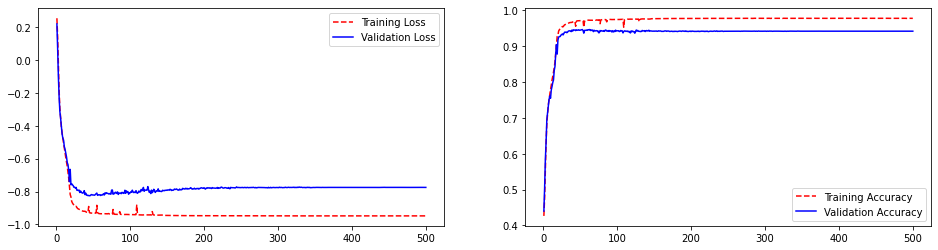

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize = (16, 4))

training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

training_accuracy = model.history.history['dice_coef'] #dice_coef, class_tversky, iou_score
validation_accuracy = model.history.history['val_dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [11]:
model.load_weights(ckp_path)
model.evaluate(X_test, y_test)

3/3 [==============================] - 2s 298ms/step - loss: -0.7188 - dice_coef: 0.9298 - iou_score: 0.8692


[-0.7188196182250977, 0.9297823309898376, 0.869173526763916]

In [12]:
from sklearn.metrics import classification_report
pred = model.predict(X_test, batch_size=36)
print(classification_report(y_test.flatten()>0.5, pred.flatten()>0.5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97  13222228
           1       0.93      0.93      0.93   5914284

    accuracy                           0.96  19136512
   macro avg       0.95      0.95      0.95  19136512
weighted avg       0.96      0.96      0.96  19136512



In [13]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test.flatten()>0.5, pred.flatten()>0.5).ravel()
acc = (tn+tp)/(tn+fp+fn+tp)
dice_score = 2*tp/(2*tp+fp+fn)
prcs = tp/(tp+fp)
rc = tp/(tp+fn)
print("Accuracy: ", acc)
print("Precision: ", prcs)
print("Recall: ", rc)
print("DSC: ", dice_score)

Accuracy:  0.9561158271685039
Precision:  0.9310569670338931
Recall:  0.926621041532669
DSC:  0.9288337080384631


In [14]:
model.load_weights('./trained_weights/FCN_bce_diceloss_Adam_500epochs.hdf5')